In [1]:
import sys

sys.path.append("./utils/")

from config import MINIMUM_GAMEPLAY_COLUMNS
from config import KEEP_COLS_PT
from datetime import timedelta
from get_delta_dna_data import execute_query

In [2]:
file_path = 'sql/events_live_3.6+.sql'
with open(file_path, "r") as f:
    query = f.read()

columns = MINIMUM_GAMEPLAY_COLUMNS

In [3]:
df = execute_query(query, columns)

In [4]:
df.shape

(753, 12)

In [5]:
df.head()

,userid,childid,eventname,eventtimestamp,mssincelastevent,timezoneoffset,gausercountry,clientversion,pnsmode,pnsword,pnsduration,pnsmistakes
0,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,areaSummary,2023-05-06 19:19:32.732,28641.0,-0400,US,3.8.0,None,None,NaN,NaN
1,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,transaction,2023-05-04 22:41:19.798,NaN,-0400,US,3.8.0,None,None,NaN,NaN
2,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,areaSummary,2023-05-07 01:03:40.557,805.0,-0400,US,3.8.0,None,None,NaN,NaN
3,000ad428-f561-4586-b6bb-6587e6e39832,None,gameStarted,2023-05-29 17:27:28.867,NaN,-0400,US,3.8.1,None,None,NaN,NaN
4,000ad428-f561-4586-b6bb-6587e6e39832,None,clientDevice,2023-05-29 17:27:28.872,5.0,-0400,US,3.8.1,None,None,NaN,NaN


In [6]:
events_live_data = df.copy()

In [7]:
# events_live_data = events_live_data[~events_live_data['timezoneoffset'].isnull()]

In [8]:
# Adjusted Date Times CTE
events_live_data = events_live_data[~events_live_data['timezoneoffset'].isnull()]
adjusted_date_times = events_live_data.copy()
adjusted_date_times["local_timestamp"] = adjusted_date_times.apply(
    lambda row: row["eventtimestamp"] + timedelta(
        minutes=int(row["timezoneoffset"][:3]) * 60 + int(row["timezoneoffset"][3:5])
    ) if len(row["timezoneoffset"]) > 0 else row["eventtimestamp"],
    axis=1
)
adjusted_date_times["local_eventdate"] = adjusted_date_times["local_timestamp"].dt.floor("D")
adjusted_date_times["local_startdate"] = adjusted_date_times.groupby("userid")["local_eventdate"].transform("min")

# Play Time CTE
play_time = adjusted_date_times.sort_values(['childid', 'local_timestamp']) .copy()

play_time["minutes_played"] = (
    play_time.groupby("childid")["mssincelastevent"]
    .cumsum()
    .div(60000)
)

play_time["ms_played"] = (
    play_time.groupby("childid")["mssincelastevent"]
    .cumsum()
    # .div(60000)
)

# Calculate the "exposures" column
completed = adjusted_date_times.copy()
completed = completed[completed["eventname"] == "pnsCompleted"]
completed = completed[~completed["pnsmode"].str.startswith("Pop")]

# Sort the DataFrame by childid, local_timestamp, and pnsword
completed = completed.sort_values(["childid", "local_timestamp", "pnsword"])

# Calculate the "exposures" column based on word changes
completed["exposures"] = (
    completed.groupby(["childid", "pnsword"])
    .cumcount()
    .add(1)
)


# Calculate day_exp and day_since_start
completed["day_exp"] = completed.groupby(["childid", "pnsword"])["local_timestamp"].transform(
    lambda x: (x - x.iloc[0]).dt.days
)
completed["day_since_start"] = completed["local_eventdate"] - completed["local_startdate"]


# Merge with play_time
result = completed.merge(
    play_time[["childid", "local_timestamp", "minutes_played"]],
    on=["childid", "local_timestamp"]
)

# Keep only the columns we need
result = result[KEEP_COLS_PT]

In [9]:
result[result['exposures']==8]

,userid,childid,local_eventdate,local_timestamp,local_startdate,gausercountry,clientversion,pnsmode,pnsword,pnsduration,pnsmistakes,exposures,day_since_start,minutes_played
41,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,2023-05-22,2023-05-22 18:28:31.443,2023-04-04,US,3.8.1,MatchSentenceBlank,14d3bc08-9522-4db3-8b43-f5d07af8c0be,13.253906,2.0,8,48 days,121.164500
42,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,2023-05-22,2023-05-22 18:28:41.563,2023-04-04,US,3.8.1,MatchSentenceBlank,b7e25d09-fa97-4ec0-b78f-74970235d2d8,7.559402,0.0,8,48 days,121.333167


In [12]:
# play_time[play_time['local_eventdate']>'2023-05-01'].head(20)

# play_time.iloc[190:198]

play_time.head(20)

,userid,childid,eventname,eventtimestamp,mssincelastevent,timezoneoffset,gausercountry,clientversion,pnsmode,pnsword,pnsduration,pnsmistakes,local_timestamp,local_eventdate,local_startdate,minutes_played,ms_played
101,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,onboarding,2023-04-05 00:54:47.393,14017.0,-0400,US,3.7.1,None,None,NaN,NaN,2023-04-04 20:54:47.393,2023-04-04,2023-04-04,0.233617,14017.0
108,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,onboarding,2023-04-05 00:54:47.636,243.0,-0400,US,3.7.1,None,None,NaN,NaN,2023-04-04 20:54:47.636,2023-04-04,2023-04-04,0.237667,14260.0
59,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,areaSummary,2023-04-29 15:59:12.021,4804.0,-0500,US,3.7.1,None,None,NaN,NaN,2023-04-29 10:59:12.021,2023-04-29,2023-04-04,0.317733,19064.0
691,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,areaSummary,2023-04-29 15:59:13.946,500.0,-0500,US,3.7.1,None,None,NaN,NaN,2023-04-29 10:59:13.946,2023-04-29,2023-04-04,0.326067,19564.0
663,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,onboarding,2023-04-29 15:40:43.373,2476.0,-0400,US,3.7.1,None,None,NaN,NaN,2023-04-29 11:40:43.373,2023-04-29,2023-04-04,0.367333,22040.0
536,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,onboarding,2023-04-29 15:40:43.814,14.0,-0400,US,3.7.1,None,None,NaN,NaN,2023-04-29 11:40:43.814,2023-04-29,2023-04-04,0.367567,22054.0
665,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,onboarding,2023-04-29 15:40:50.936,2866.0,-0400,US,3.7.1,None,None,NaN,NaN,2023-04-29 11:40:50.936,2023-04-29,2023-04-04,0.415333,24920.0
540,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,onboarding,2023-04-29 15:40:59.313,8377.0,-0400,US,3.7.1,None,None,NaN,NaN,2023-04-29 11:40:59.313,2023-04-29,2023-04-04,0.554950,33297.0
68,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,onboarding,2023-04-29 15:41:03.408,4095.0,-0400,US,3.7.1,None,None,NaN,NaN,2023-04-29 11:41:03.408,2023-04-29,2023-04-04,0.623200,37392.0
658,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,onboarding,2023-04-29 15:41:05.138,1730.0,-0400,US,3.7.1,None,None,NaN,NaN,2023-04-29 11:41:05.138,2023-04-29,2023-04-04,0.652033,39122.0


In [13]:
play_time.shape

(753, 17)

In [14]:
play_time.childid.isna().sum()

394

In [15]:
import seaborn as sns

In [17]:
import pandas as pd
df2 = pd.read_csv('data/playing_time_to_exposure_wib_sd.csv')

In [27]:
words = df2[df2['EXPOSURES']==8]

# words['diff'] = words['LOCAL_EVENTDATE'] - words['LOCAL_STARTDATE']

<AxesSubplot: xlabel='WIB', ylabel='MINUTES_PLAYED'>

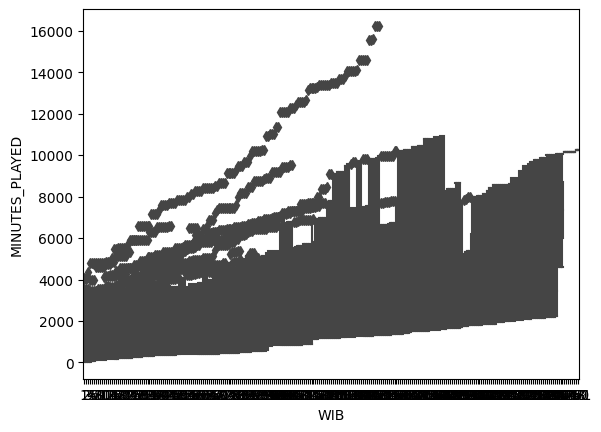

In [29]:
# create a boxplot of the minutes_played column by wib 
sns.boxplot(x='WIB', y='MINUTES_PLAYED', data=words)

In [30]:
words.head()

,USERID,CHILDID,LOCAL_EVENTDATE,LOCAL_TIMESTAMP,LOCAL_STARTDATE,GAUSERCOUNTRY,CLIENTVERSION,PNSMODE,PNSWORD,PNSDURATION,PNSMISTAKES,EXPOSURES,DAY_SINCE_START,WIB,MINUTES_PLAYED
41,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,2023-05-22,2023-05-22 18:28:31.443,2023-04-04,US,3.8.1,MatchSentenceBlank,14d3bc08-9522-4db3-8b43-f5d07af8c0be,13.253906,2,8,48,1,121.2
42,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,2023-05-22,2023-05-22 18:28:41.563,2023-04-04,US,3.8.1,MatchSentenceBlank,b7e25d09-fa97-4ec0-b78f-74970235d2d8,7.559402,0,8,48,2,121.3
96,00126038-0fd5-47a1-aced-39406c35fc0d,d1a76a5a38b796eba2c7da449e57d9caf50dfc9f,2023-06-08,2023-06-08 10:57:29.078,2023-04-22,AU,3.8.1,MatchSentenceBlank,c22360b3-c723-4660-93a5-b79c2b791821,11.329742,0,8,47,1,589.3
97,00126038-0fd5-47a1-aced-39406c35fc0d,d1a76a5a38b796eba2c7da449e57d9caf50dfc9f,2023-06-08,2023-06-08 10:57:40.169,2023-04-22,AU,3.8.1,MatchSentenceBlank,7d1e5cb9-5ca1-481d-bd4e-5bac48e62c40,8.563904,0,8,47,2,589.5
109,00126038-0fd5-47a1-aced-39406c35fc0d,d1a76a5a38b796eba2c7da449e57d9caf50dfc9f,2023-06-25,2023-06-25 08:39:12.686,2023-04-22,AU,3.9.2,MatchSentenceBlank,ce9bdfaa-4bed-45bf-95e4-8852b4c52de1,13.828735,0,8,64,3,648.3


In [38]:
words.loc[:,'HOURS'] = words.loc[:, 'MINUTES_PLAYED']/60

/var/folders/h4/3j86d14x3ggfxhzc869_k0kr0000gn/T/ipykernel_16533/99052882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words.loc[:,'HOURS'] = words.loc[:, 'MINUTES_PLAYED']/60


In [40]:
words.head()

,USERID,CHILDID,LOCAL_EVENTDATE,LOCAL_TIMESTAMP,LOCAL_STARTDATE,GAUSERCOUNTRY,CLIENTVERSION,PNSMODE,PNSWORD,PNSDURATION,PNSMISTAKES,EXPOSURES,DAY_SINCE_START,WIB,MINUTES_PLAYED,hours,HOURS
41,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,2023-05-22,2023-05-22 18:28:31.443,2023-04-04,US,3.8.1,MatchSentenceBlank,14d3bc08-9522-4db3-8b43-f5d07af8c0be,13.253906,2,8,48,1,121.2,2.020000,2.020000
42,000ad428-f561-4586-b6bb-6587e6e39832,056a6862697766655a23e8a6ece42ac27d6747fb,2023-05-22,2023-05-22 18:28:41.563,2023-04-04,US,3.8.1,MatchSentenceBlank,b7e25d09-fa97-4ec0-b78f-74970235d2d8,7.559402,0,8,48,2,121.3,2.021667,2.021667
96,00126038-0fd5-47a1-aced-39406c35fc0d,d1a76a5a38b796eba2c7da449e57d9caf50dfc9f,2023-06-08,2023-06-08 10:57:29.078,2023-04-22,AU,3.8.1,MatchSentenceBlank,c22360b3-c723-4660-93a5-b79c2b791821,11.329742,0,8,47,1,589.3,9.821667,9.821667
97,00126038-0fd5-47a1-aced-39406c35fc0d,d1a76a5a38b796eba2c7da449e57d9caf50dfc9f,2023-06-08,2023-06-08 10:57:40.169,2023-04-22,AU,3.8.1,MatchSentenceBlank,7d1e5cb9-5ca1-481d-bd4e-5bac48e62c40,8.563904,0,8,47,2,589.5,9.825000,9.825000
109,00126038-0fd5-47a1-aced-39406c35fc0d,d1a76a5a38b796eba2c7da449e57d9caf50dfc9f,2023-06-25,2023-06-25 08:39:12.686,2023-04-22,AU,3.9.2,MatchSentenceBlank,ce9bdfaa-4bed-45bf-95e4-8852b4c52de1,13.828735,0,8,64,3,648.3,10.805000,10.805000


In [42]:
words.groupby('WIB')['HOURS'].describe().head(20)

,count,mean,std,min,25%,50%,75%,max
WIB,,,,,,,,
1,4966.0,5.223693,4.575476,0.416667,2.604583,3.942500,6.242500,67.770000
2,4382.0,5.652495,4.890608,0.468333,2.847500,4.261667,6.804583,67.775000
3,3997.0,5.946540,5.087832,0.585000,3.023333,4.498333,7.098333,72.636667
4,3409.0,6.543227,5.480313,0.753333,3.385000,4.996667,7.873333,80.223333
5,2847.0,7.473395,5.914749,0.968333,3.963333,5.828333,8.921667,80.230000
6,2376.0,8.336853,6.475879,1.458333,4.540000,6.557500,9.887083,80.230000
7,2108.0,8.992627,6.939820,1.638333,4.901667,7.080000,10.602500,80.266667
8,1911.0,9.397343,6.972374,1.643333,5.201667,7.556667,11.170000,80.271667
9,1718.0,10.008070,7.235641,1.646667,5.685000,8.013333,11.990000,80.276667


In [58]:
sub = words[words['WIB'] <= 5]

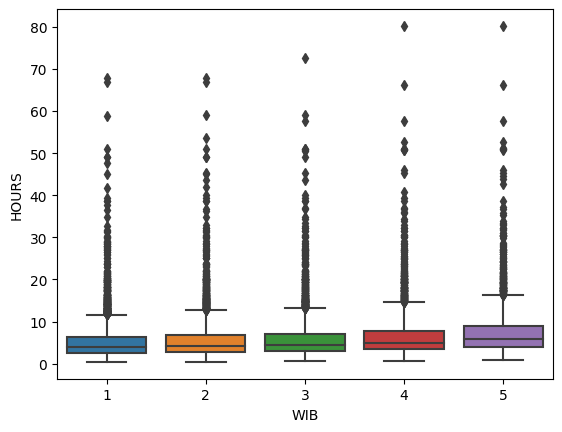

In [59]:
sns.boxplot(x='WIB', y='HOURS', data=sub);